In [2]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
from numpy.random import normal, choice, rand, beta, binomial, randint, dirichlet
from numpy.linalg import matrix_rank, norm, svd, eig, qr
from scipy.linalg import pinv2
from scipy import interpolate
from scipy.stats import entropy
def pinv(x): return pinv2(x, rcond=10 * np.finfo(float).eps)
import time

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [17]:
ncfile = Dataset("air.202010.nc")
air = np.squeeze(ncfile.variables['air'])
ncfile.close()
air = air[:,16,:252,1:337]

In [18]:
A = air
del air
N = A.shape

In [20]:
N

(248, 252, 336)

In [21]:
# matrix unfoldings
A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
tmp = np.moveaxis(A,0,2) # 1 2 0
A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
tmp = np.moveaxis(A,2,0) # 2 0 1
A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])

In [22]:
def HOSVD_rank(A):
    A1 = A.reshape(A.shape[0],A.shape[1]*A.shape[2]) # 1 2 3
    tmp = np.moveaxis(A,0,2) # 2 3 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 3 1 2
    A3 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    U1, s1, V1 = svd(A1,full_matrices=False)
    U2, s2, V2 = svd(A2,full_matrices=False)
    U3, s3, V3 = svd(A3,full_matrices=False)
    
    scree1 = []
    scree2 = []
    scree3 = []
    for r in tqdm(range(s1.shape[0])):
        scree1.append(norm(s1[r+1:])**2 / norm(A1)**2)
        if norm(s1[r+1:])**2 / norm(A1)**2 < 1e-7 :
                break
    for r in tqdm(range(s2.shape[0])):
        scree2.append(norm(s2[r+1:])**2 / norm(A2)**2)
        if norm(s2[r+1:])**2 / norm(A2)**2 < 1e-7 :
                break
    for r in tqdm(range(s3.shape[0])):
        scree3.append(norm(s3[r+1:])**2 / norm(A3)**2)   
        if norm(s3[r+1:])**2 / norm(A3)**2 < 1e-7 :
                break
                
    return [scree1, scree2, scree3]

In [23]:
scree = HOSVD_rank(A)

 15%|███████████▋                                                                    | 49/336 [00:00<00:02, 119.19it/s]


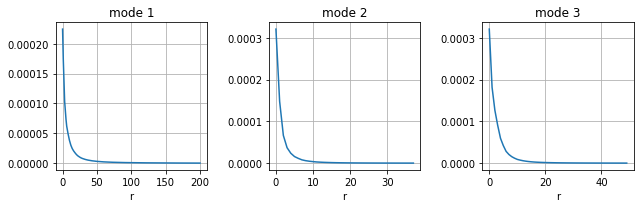

In [24]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(scree[0])
ax[0].set_title('mode 1')
ax[0].set_xlabel('r')
#ax[0].set_xticks(np.arange(0, N[0], 50))
ax[0].grid()

ax[1].plot(scree[1])
ax[1].set_title('mode 2')
ax[1].set_xlabel('r')
#ax[1].set_xticks(np.arange(0, N[1], 20))
ax[1].grid()

ax[2].plot(scree[2])
ax[2].set_title('mode 3')
ax[2].set_xlabel('r')
#ax[2].set_xticks(np.arange(0, N[2], 20))
ax[2].grid()
plt.tight_layout()
plt.savefig('../plots/air_screes.png',dpi=300)
plt.show()

In [25]:
# SAD
sad_0 = np.sum(np.abs(np.diff(A0,axis=1)),axis=1)
sad_0 = sad_0 / np.sum(sad_0)
sad_1 = np.sum(np.abs(np.diff(A1,axis=1)),axis=1)
sad_1 = sad_1 / np.sum(sad_1)
sad_2 = np.sum(np.abs(np.diff(A2,axis=1)),axis=1)
sad_2 = sad_2 / np.sum(sad_2)

In [26]:
entropy(sad_0)

5.511044

In [27]:
entropy(sad_1)

5.478473

In [28]:
entropy(sad_2)

5.8025694

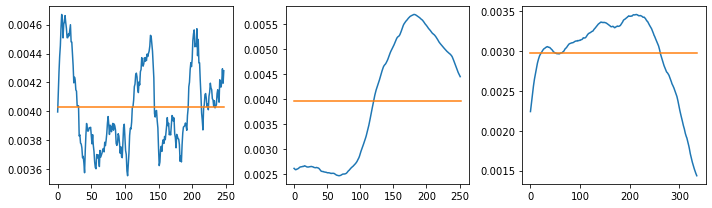

In [29]:
fig, ax = plt.subplots(1,3,figsize=[10,3])
ax[0].plot(sad_0)
ax[0].plot([0,N[0]],[np.mean(sad_0),np.mean(sad_0)])
ax[1].plot(sad_1)
ax[1].plot([0,N[1]],[np.mean(sad_1),np.mean(sad_1)])
ax[2].plot(sad_2)
ax[2].plot([0,N[2]],[np.mean(sad_2),np.mean(sad_2)])
plt.tight_layout()
plt.show()

In [30]:
r = np.array([50,10,20])

In [64]:
errRS = []
timeRS = []
for _ in tqdm(range(100)):
    _, err, t = Random_SketchyCoreTucker(A,r,300)
    errRS.append(err)
    timeRS.append(t)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]


In [35]:
errPS = []
timePS = []
for _ in tqdm(range(100)):
    _, err, m, t = pgSketchyCoreTucker(A,r,10,10,300)
    errPS.append(err)
    timePS.append(t)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:51<00:00,  2.32s/it]


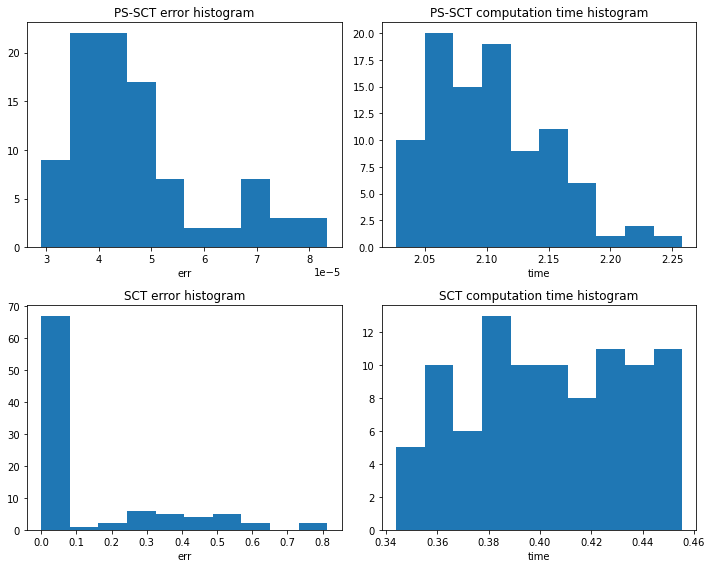

In [65]:
f, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].hist(np.sort(errPS)[3:-3])
ax[0,0].set_xlabel('err')
ax[0,0].set_title('PS-SCT error histogram')
ax[0,1].hist(np.sort(timePS)[3:-3])
ax[0,1].set_xlabel('time')
ax[0,1].set_title('PS-SCT computation time histogram')
ax[1,0].hist(np.sort(errRS)[3:-3])
ax[1,0].set_xlabel('err')
ax[1,0].set_title('SCT error histogram')
ax[1,1].hist(np.sort(timeRS)[3:-3])
ax[1,1].set_xlabel('time')
ax[1,1].set_title('SCT computation time histogram')
plt.tight_layout()
plt.savefig('../plots/air_result.png',dpi=300)
plt.show()

In [38]:
print(np.mean(np.sort(errPS)[3:-3]))
print(np.mean(np.sort(errRS)[3:-3]))

4.7067550851784056e-05
0.19662147271921465


In [39]:
print(np.mean(np.sort(timePS)[3:-3]))
print(np.mean(np.sort(timeRS)[3:-3]))

2.1050308460884906
0.39313464722734814


In [43]:
0.000047

4.7e-05

In [155]:
_, err, t = SketchyCoreTucker(A,r,[50,125,125])
err

0.7398512495835704

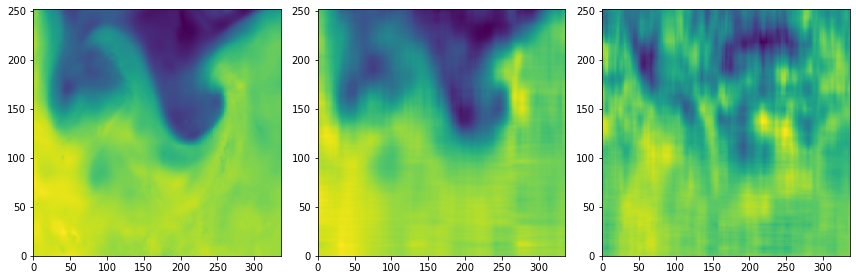

In [47]:
f, ax = plt.subplots(1,3,figsize=[12,4])
ax[0].pcolormesh(A[0])
A_PS, err, m, t = pgSketchyCoreTucker(A,r,10,10,300)
ax[1].pcolormesh(A_PS[0])
A_RS, err, t = Random_SketchyCoreTucker(A,r,300)
ax[2].pcolormesh(A_RS[0])
plt.tight_layout()
plt.savefig('../plots/air_Ar.png',dpi=300)
plt.show()

In [31]:
def HOSVD(A):
    A1 = A.reshape(A.shape[0],A.shape[1]*A.shape[2]) # 1 2 3
    tmp = np.moveaxis(A,0,2) # 2 3 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 3 1 2
    A3 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    U1, s1, V1 = svd(A1,full_matrices=False)
    U2, s2, V2 = svd(A2,full_matrices=False)
    U3, s3, V3 = svd(A3,full_matrices=False)
    
    S = np.tensordot(np.tensordot(np.tensordot(A,U1.T,axes=(0,1)),
                              U2.T,axes=(0,1)),
                 U3.T,axes=(0,1))
    return S, U1, U2, U3

def linear(index,score,N):
    f = interpolate.interp1d(index, score)
    z = f(np.arange(N))
    z[index] = 0
    if np.sum(z) > 0:
        return z / np.sum(z)
    if np.sum(z) == 0:
        return None

In [32]:
def pgSketchyCoreTucker(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # computation time log
    start_time = time.time()
    
    # matrix unfoldings
    A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
    tmp = np.moveaxis(A,0,2) # 1 2 0
    A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 2 0 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    
    # SAD
    score_0 = np.sum(np.abs(np.diff(A0[index_0,:],axis=1)),axis=1)
    score_1 = np.sum(np.abs(np.diff(A1[index_1,:],axis=1)),axis=1)
    score_2 = np.sum(np.abs(np.diff(A2[index_2,:],axis=1)),axis=1)
    
    # bilinear interpolation
    z_0 = linear(index_0,score_0,N[0])
    z_1 = linear(index_1,score_1,N[1])
    z_2 = linear(index_2,score_2,N[2])
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)
        
        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            index_0 = np.append(index_0,choice(N[0],add,replace=False,p=z_0))
            score_0 = np.sum(np.abs(np.diff(A0[index_0,:],axis=1)),axis=1)
            z_0 = linear(index_0,score_0,N[0])
            params[0] = entropy(score_0)
            
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            index_1 = np.append(index_1,choice(N[1],add,replace=False,p=z_1))
            score_1 = np.sum(np.abs(np.diff(A1[index_1,:],axis=1)),axis=1)
            z_1 = linear(index_1,score_1,N[1])
            params[1] = entropy(score_1)
        
        if z_2 is not None:
            if np.sum(z_2>0) > theta[2]:
                add = theta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            index_2 = np.append(index_2,choice(N[2],add,replace=False,p=z_2))
            score_2 = np.sum(np.abs(np.diff(A2[index_2,:],axis=1)),axis=1)
            z_2 = linear(index_2, score_2, N[2])
            params[2] = entropy(score_2)
            

    # Final SketchyCoreTucker
    y0, x0 = np.meshgrid(index_1,index_2)
    y1, x1 = np.meshgrid(index_2,index_0)
    y2, x2 = np.meshgrid(index_0,index_1)
    fibers_0 = (x0 + y0*N[2]).reshape(-1)
    fibers_1 = (x1 + y1*N[0]).reshape(-1)
    fibers_2 = (x2 + y2*N[1]).reshape(-1)
    
    k = np.array(r + (m-r)/3,dtype=np.int) 
    s = np.array(r + 2*(m-r)/3,dtype=np.int)
    
    Map0_T = normal(size=(len(fibers_0),k[0]))
    Map1_T = normal(size=(len(fibers_1),k[1]))
    Map2_T = normal(size=(len(fibers_2),k[2]))
    
    Y0 = A0[:,fibers_0] @ Map0_T
    Y1 = A1[:,fibers_1] @ Map1_T
    Y2 = A2[:,fibers_2] @ Map2_T

    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))
    
    Map0 = normal(size=(s[0],m[0]))
    Map1 = normal(size=(s[1],m[1]))
    Map2 = normal(size=(s[2],m[2]))
    
    delta0, delta1, delta2 = np.meshgrid(index_0, index_1, index_2, indexing='ij')
    Z = np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2],Map0,axes=(0,1)),
                                  Map1,axes=(0,1)),
                     Map2,axes=(0,1))
    
    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))
    
    C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                  pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                     pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1))
    
    S, U1, U2, U3 = HOSVD(C)
    
    Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                   U2[:,:r[1]],axes=(0,1)),
                      U3[:,:r[2]],axes=(0,1))
    
    time_TS = time.time() - start_time  
    
    Ar = np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                   Q1,axes=(0,1)),
                      Q2,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
    
    return Ar, err, m, time_TS

In [33]:
def Random_SketchyCoreTucker(A,r,M):
    N = np.array(A.shape)
    m = N+1
    while (m[0] > N[0]) or (m[1] > N[1]) or (m[2] > N[2]):
        m = np.array(dirichlet([1,1,1],1)[0] * M,dtype=np.int)
    k = np.array(r + (m-r)/3,dtype=np.int) 
    s = np.array(r + 2*(m-r)/3,dtype=np.int)
    
    # computation time log
    start_time = time.time()
    
    # matrix unfoldings
    A0 = A.reshape(N[0],N[1]*N[2]) # 1 2 3
    tmp = np.moveaxis(A,0,2) # 2 3 1
    A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 3 1 2
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    
    # inital core uniform sampling
    index_0 = choice(N[0], size=m[0], replace=False)
    index_1 = choice(N[1], size=m[1], replace=False) 
    index_2 = choice(N[2], size=m[2], replace=False)
    
    fibers_0 = choice(N[1]*N[2],m[1]*m[2],replace=False)
    fibers_1 = choice(N[2]*N[0],m[2]*m[0],replace=False)
    fibers_2 = choice(N[0]*N[1],m[0]*m[1],replace=False)
    
    Map0_T = normal(size=(len(fibers_0),k[0]))
    Map1_T = normal(size=(len(fibers_1),k[1]))
    Map2_T = normal(size=(len(fibers_2),k[2]))
    
    Y0 = A0[:,fibers_0] @ Map0_T
    Y1 = A1[:,fibers_1] @ Map1_T
    Y2 = A2[:,fibers_2] @ Map2_T

    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))
    
    Map0 = normal(size=(s[0],m[0]))
    Map1 = normal(size=(s[1],m[1]))
    Map2 = normal(size=(s[2],m[2]))
    
    delta0, delta1, delta2 = np.meshgrid(index_0, index_1, index_2, indexing='ij')
    Z = np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2],Map0,axes=(0,1)),
                                  Map1,axes=(0,1)),
                     Map2,axes=(0,1))
    
    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))
    
    C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                  pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                     pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1))
    
    S, U1, U2, U3 = HOSVD(C)
    
    Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                   U2[:,:r[1]],axes=(0,1)),
                      U3[:,:r[2]],axes=(0,1))
    
    time_TS = time.time() - start_time 
    
    Ar = np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                   Q1,axes=(0,1)),
                      Q2,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
        
    return Ar, err, time_TS

In [48]:
def pgskt_log(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # matrix unfoldings
    A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
    tmp = np.moveaxis(A,0,2) # 1 2 0
    A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 2 0 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    index_0_log = [index_0.tolist()]
    index_1_log = [index_1.tolist()]
    index_2_log = [index_2.tolist()]
    
    # SAD
    score_0 = np.sum(np.abs(np.diff(A0[index_0,:],axis=1)),axis=1)
    score_1 = np.sum(np.abs(np.diff(A1[index_1,:],axis=1)),axis=1)
    score_2 = np.sum(np.abs(np.diff(A2[index_2,:],axis=1)),axis=1)
    
    # bilinear interpolation
    z_0 = linear(index_0,score_0,N[0])
    z_1 = linear(index_1,score_1,N[1])
    z_2 = linear(index_2,score_2,N[2])
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)
        
        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            index_0 = np.append(index_0,choice(N[0],add,replace=False,p=z_0))
            #Q0, _ = qr(A0[index_0,:])
            #score_0 = np.sum(Q0**2,axis=1)/np.sum(Q0**2)
            score_0 = np.sum(np.abs(np.diff(A0[index_0,:],axis=1)),axis=1)
            z_0 = linear(index_0,score_0,N[0])

            #reward = score_0[-add:] >= np.mean(score_0)
            #params[0] += np.sum(reward)
            params[0] = entropy(score_0)
            
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            index_1 = np.append(index_1,choice(N[1],add,replace=False,p=z_1))
            #Q1, _ = qr(A1[index_1,:])
            #score_1 = np.sum(Q1**2,axis=1)/np.sum(Q1**2)
            score_1 = np.sum(np.abs(np.diff(A1[index_1,:],axis=1)),axis=1)
            z_1 = linear(index_1,score_1,N[1])

            #reward = score_1[-add:] >= np.mean(score_1)
            #params[1] += np.sum(reward)
            params[1] = entropy(score_1)
        
        if z_2 is not None:
            if np.sum(z_2>0) > theta[2]:
                add = theta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            index_2 = np.append(index_2,choice(N[2],add,replace=False,p=z_2))
            #Q2, _ = qr(A2[index_2,:])
            #score_2 = np.sum(Q2**2,axis=1)/np.sum(Q2**2)
            score_2 = np.sum(np.abs(np.diff(A2[index_2,:],axis=1)),axis=1)
            z_2 = linear(index_2, score_2, N[2])

            #reward = score_2[-add:] >= np.mean(score_2)
            #params[2] += np.sum(reward)
            params[2] = entropy(score_2)
            
        index_0_log.append(index_0.tolist())
        index_1_log.append(index_1.tolist())
        index_2_log.append(index_2.tolist())
            
    return index_0_log, index_1_log, index_2_log

In [49]:
def rdskt_log(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # matrix unfoldings
    A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
    tmp = np.moveaxis(A,0,2) # 1 2 0
    A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 2 0 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    index_0_log = [index_0.tolist()]
    index_1_log = [index_1.tolist()]
    index_2_log = [index_2.tolist()]
    
        
    # bilinear interpolation
    z_0 = np.arange(N[0])
    z_0[index_0] = 0
    z_0 = z_0/np.sum(z_0)
    
    z_1 = np.arange(N[1])
    z_1[index_1] = 0
    z_1 = z_1/np.sum(z_1)
    
    z_2 = np.arange(N[2])
    z_2[index_2] = 0
    z_2 = z_2/np.sum(z_2)
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)

        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            index_0 = np.append(index_0,choice(N[0],add,replace=False,p=z_0))
            z_0[index_0] = 0
            if np.sum(z_0) > 0:
                z_0 = z_0/np.sum(z_0)
            if np.sum(z_0) == 0:
                z_0 = None
            
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            index_1 = np.append(index_1,choice(N[1],add,replace=False,p=z_1))
            z_1[index_1] = 0
            if np.sum(z_1) > 0:
                z_1 = z_1/np.sum(z_1)
            if np.sum(z_1) == 0:
                z_1 = None

        if z_2 is not None:
            if np.sum(z_2>0) > theta[2]:
                add = theta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            index_2 = np.append(index_2,choice(N[2],add,replace=False,p=z_2))
            z_2[index_2] = 0
            if np.sum(z_2) > 0:
                z_2 = z_2/np.sum(z_2)
            if np.sum(z_2) == 0:
                z_2 = None
                
        index_0_log.append(index_0.tolist())
        index_1_log.append(index_1.tolist())
        index_2_log.append(index_2.tolist())
            
    return index_0_log, index_1_log, index_2_log

In [50]:
def lc(N, logPS_0, logPS_1, logPS_2):
    err_log = []
    for index_0, index_1, index_2 in zip(logPS_0,logPS_1,logPS_2):
        m = [len(index_0),len(index_1),len(index_2)]
        
        y0, x0 = np.meshgrid(index_1,index_2)
        y1, x1 = np.meshgrid(index_2,index_0)
        y2, x2 = np.meshgrid(index_0,index_1)
        fibers_0 = (x0 + y0*N[2]).reshape(-1)
        fibers_1 = (x1 + y1*N[0]).reshape(-1)
        fibers_2 = (x2 + y2*N[1]).reshape(-1)

        k = np.array(r + (m-r)/3,dtype=np.int) 
        s = np.array(r + 2*(m-r)/3,dtype=np.int)

        Map0_T = normal(size=(len(fibers_0),k[0]))
        Map1_T = normal(size=(len(fibers_1),k[1]))
        Map2_T = normal(size=(len(fibers_2),k[2]))

        Y0 = A0[:,fibers_0] @ Map0_T
        Y1 = A1[:,fibers_1] @ Map1_T
        Y2 = A2[:,fibers_2] @ Map2_T

        Q0, _ = qr(np.array(Y0))
        Q1, _ = qr(np.array(Y1))
        Q2, _ = qr(np.array(Y2))

        Map0 = normal(size=(s[0],m[0]))
        Map1 = normal(size=(s[1],m[1]))
        Map2 = normal(size=(s[2],m[2]))

        delta0, delta1, delta2 = np.meshgrid(index_0, index_1, index_2, indexing='ij')
        Z = np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2],Map0,axes=(0,1)),
                                      Map1,axes=(0,1)),
                         Map2,axes=(0,1))

        Q0, _ = qr(np.array(Y0))
        Q1, _ = qr(np.array(Y1))
        Q2, _ = qr(np.array(Y2))

        C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                      pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                         pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1))

        S, U1, U2, U3 = HOSVD(C)

        Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                       U2[:,:r[1]],axes=(0,1)),
                          U3[:,:r[2]],axes=(0,1))

        Ar = np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                       Q1,axes=(0,1)),
                          Q2,axes=(0,1))

        err = norm(A - Ar)**2 / norm(A)**2
        
        err_log.append(err)
        
    return err_log

In [51]:
def Ahat(N, index_0, index_1, index_2):

    m = [len(index_0),len(index_1),len(index_2)]

    y0, x0 = np.meshgrid(index_1,index_2)
    y1, x1 = np.meshgrid(index_2,index_0)
    y2, x2 = np.meshgrid(index_0,index_1)
    fibers_0 = (x0 + y0*N[2]).reshape(-1)
    fibers_1 = (x1 + y1*N[0]).reshape(-1)
    fibers_2 = (x2 + y2*N[1]).reshape(-1)

    k = np.array(r + (m-r)/3,dtype=np.int) 
    s = np.array(r + 2*(m-r)/3,dtype=np.int)

    Map0_T = normal(size=(len(fibers_0),k[0]))
    Map1_T = normal(size=(len(fibers_1),k[1]))
    Map2_T = normal(size=(len(fibers_2),k[2]))

    Y0 = A0[:,fibers_0] @ Map0_T
    Y1 = A1[:,fibers_1] @ Map1_T
    Y2 = A2[:,fibers_2] @ Map2_T

    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))

    Map0 = normal(size=(s[0],m[0]))
    Map1 = normal(size=(s[1],m[1]))
    Map2 = normal(size=(s[2],m[2]))

    delta0, delta1, delta2 = np.meshgrid(index_0, index_1, index_2, indexing='ij')
    Z = np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2],Map0,axes=(0,1)),
                                  Map1,axes=(0,1)),
                     Map2,axes=(0,1))

    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))

    C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                  pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                     pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1))

    S, U1, U2, U3 = HOSVD(C)

    Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                   U2[:,:r[1]],axes=(0,1)),
                      U3[:,:r[2]],axes=(0,1))

    Ar = np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                   Q1,axes=(0,1)),
                      Q2,axes=(0,1))
        
    return Ar

In [71]:
logPS_0, logPS_1, logPS_2 = pgskt_log(A,r,10,10,500)
err_logPS = lc(N,logPS_0, logPS_1, logPS_2)

In [72]:
logRS_0, logRS_1, logRS_2 = rdskt_log(A,r,10,10,500)
err_logRS = lc(N,logRS_0, logRS_1, logRS_2)

In [73]:
nf_PS = [len(i)+len(j)+len(k) for i,j,k in zip(logPS_0,logPS_1,logPS_2)]
nf_RS = [len(i)+len(j)+len(k) for i,j,k in zip(logRS_0,logRS_1,logRS_2)]

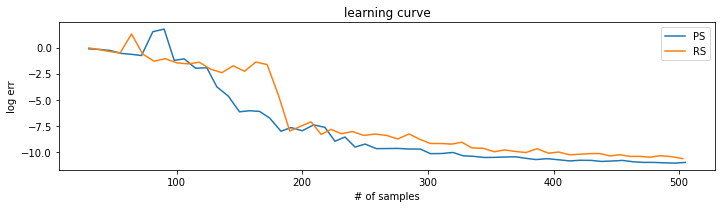

In [74]:
plt.figure(figsize=[10,3])
plt.plot(nf_PS, np.log(err_logPS),label='PS')
plt.plot(nf_RS, np.log(err_logRS),label='RS')
plt.ylabel('log err')
plt.xlabel('# of samples')
plt.title('learning curve')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/air_lc.png',dpi=300)
plt.show()

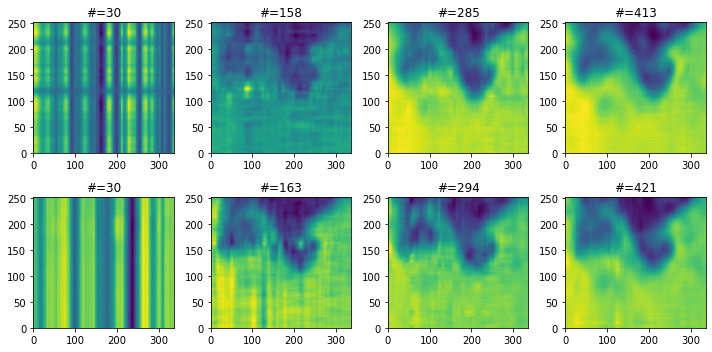

In [75]:
f, ax = plt.subplots(2,4,figsize=[10,5])
ax[0,0].pcolormesh(Ahat(N,logPS_0[0],logPS_1[0],logPS_2[0])[0,:,:])
ax[0,1].pcolormesh(Ahat(N,logPS_0[15],logPS_1[15],logPS_2[15])[0,:,:])
ax[0,2].pcolormesh(Ahat(N,logPS_0[30],logPS_1[30],logPS_2[30])[0,:,:])
ax[0,3].pcolormesh(Ahat(N,logPS_0[45],logPS_1[45],logPS_2[45])[0,:,:])

ax[0,0].set_title('#=' + str(nf_PS[0]))
ax[0,1].set_title('#=' + str(nf_PS[15]))
ax[0,2].set_title('#=' + str(nf_PS[30]))
ax[0,3].set_title('#=' + str(nf_PS[45]))

ax[1,0].pcolormesh(Ahat(N,logRS_0[0],logRS_1[0],logRS_2[0])[0,:,:])
ax[1,1].pcolormesh(Ahat(N,logRS_0[15],logRS_1[15],logRS_2[15])[0,:,:])
ax[1,2].pcolormesh(Ahat(N,logRS_0[30],logRS_1[30],logRS_2[30])[0,:,:])
ax[1,3].pcolormesh(Ahat(N,logRS_0[45],logRS_1[45],logRS_2[45])[0,:,:])

ax[1,0].set_title('#=' + str(nf_RS[0]))
ax[1,1].set_title('#=' + str(nf_RS[15]))
ax[1,2].set_title('#=' + str(nf_RS[30]))
ax[1,3].set_title('#=' + str(nf_RS[45]))

plt.tight_layout()
plt.savefig('../plots/air_Ar.png',dpi=300)
plt.show()